In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from scipy.spatial import distance
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
class ForecastLSTM:
    def __init__(self, random_seed: int = 1234):
        self.random_seed = random_seed

In [3]:
def reshape_dataset(self, df: pd.DataFrame) -> np.array:
    if "y" in df.columns:
        df = df.drop(columns=["y"]).assign(y=df["y"])
    else:
        raise KeyError("Not found 'y' in dataset")
    
    dataset = df.values.reshape(df.shape)
    return dataset

ForecastLSTM.reshape_dataset = reshape_dataset

In [4]:
def split_sequences(
        self, dataset: np.array, seq_len: int, steps: int, single_output: bool
) -> tuple:
    
    # feature와 y 각각 sequential dataset을 반환할 리스트
    X, y = list(), list()
    # sequence length와 step에 따라 생성
    for i, _ in enumerate(dataset):
        idx_in = i + seq_len
        idx_out = idx_in + steps
        if idx_out > len(dataset):
            break
        seq_x = dataset[i:idx_in, :-1]
        if single_output:
            seq_y = dataset[idx_out -1 : idx_out, -1]
        else:
            seq_y = dataset[idx_in:idx_out, -1]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

ForecastLSTM.split_sequences = split_sequences

In [5]:
def split_train_valid_dataset(
        self, df: pd.DataFrame,
        seq_len: int,
        steps: int,
        single_output: bool,
        validation_split: float = 0.2,
        verbose: bool = True
) -> tuple:
    # df -> np.array
    dataset = self.reshape_dataset(df=df)

    # feature, y를 sequential dataset으로 분리
    X, y = self.split_sequences(
        dataset=dataset,
        seq_len=seq_len,
        steps=steps,
        single_output=single_output
    )

    # X, y에서 validation dataset 분리
    dataset_size = len(X)
    train_size = int(dataset_size * (1-validation_split))
    X_train, y_train = X[:train_size, :], y[:train_size, :]
    X_val, y_val = X[train_size:, :], y[train_size:, :]
    if verbose:
        print(f" >>> X_train: {X_train.shape}")
        print(f" >>> y_train: {y_train.shape}")
        print(f" >>> X_val: {X_val.shape}")
        print(f" >>> y_val: {y_val.shape}")
    return X_train, y_train, X_val, y_val


ForecastLSTM.split_train_valid_dataset = split_train_valid_dataset

In [6]:
def build_and_compile_lstm_model(
    self,
    seq_len: int,
    n_features: int,
    lstm_units: list,
    learning_rate: float,
    dropout: float,
    steps: int,
    metrics: list,
    single_output: bool,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    activation: str = None
):
    tf.random.set_seed(self.random_seed)
    model = Sequential()

    if len(lstm_units) > 1:
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=True,
                input_shape=(seq_len, n_features)
            )
        )
        lstm_layers = lstm_units[1:]
        for i, n_units in enumerate(lstm_layers, start=1):
            if i == len(lstm_layers):
                if single_output:
                    return_sequences = False
                else:
                    return_sequences = last_lstm_return_sequences
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=return_sequences
                    )
                )
            else:
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=True
                    )
                )
    else:
        if single_output:
            return_sequences = False
        else:
            return_sequences = last_lstm_return_sequences
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=return_sequences,
                input_shape=(seq_len, n_features),
            )
        )

    if single_output:
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(1))
    else:
        if last_lstm_return_sequences:
            model.add(Flatten())
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(units=steps))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=MSE, metrics=metrics)
    return model


ForecastLSTM.build_and_compile_lstm_model = build_and_compile_lstm_model

In [7]:
def fit_lstm(
    self,
    df: pd.DataFrame,
    steps: int,
    lstm_units: list,
    activation: str,
    dropout: float = 0,
    seq_len: int = 10,
    single_output: bool = False,
    epochs: int = 50,
    batch_size: int = None,
    steps_per_epoch: int = None,
    learning_rate: float = 0.001,
    patience: int = 10,
    validation_split: float = 0.2,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    metrics: list = ["mse"],
    check_point_path: str = None,
    verbose: bool = False,
    plot: bool = True
):
    
    np.random.seed(self.random_seed)
    tf.random.set_seed(self.random_seed)
    (
        self.X_train,
        self.y_train,
        self.X_val,
        self.y_val
    ) = self.split_train_valid_dataset(
        df=df,
        seq_len=seq_len,
        steps=steps,
        validation_split=validation_split,
        single_output=single_output,
        verbose=verbose
    )

    n_features = df.shape[1] - 1
    self.model = self.build_and_compile_lstm_model(
        seq_len=seq_len,
        n_features=n_features,
        lstm_units=lstm_units,
        activation=activation,
        learning_rate=learning_rate,
        dropout=dropout,
        steps=steps,
        last_lstm_return_sequences=last_lstm_return_sequences,
        dense_units=dense_units,
        metrics=metrics,
        single_output=single_output,
    )

    # best model save
    if check_point_path is not None:
        checkpoint_path = f"checkpoint/lstm_{check_point_path}.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=False,
            save_best_only=True,
            monitor="val_loss",
            verbose=verbose,
        )
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [checkpoint, EarlyStopping(patience=patience), rlr]
    else:
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [EarlyStopping(patience=patience), rlr]

    self.history = self.model.fit(
        self.X_train,
        self.y_train,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_data=(self.X_val, self.y_val),
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        shuffle=False,
    )

    if check_point_path is not None: 
        self.model.load_weights(f"checkpoint/lstm_{check_point_path}.h5")

    # 시각화
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history[f"{metrics[0]}"])
        plt.plot(self.history.history[f"val_{metrics[0]}"])
        plt.title("Performance Metric")
        plt.xlabel("Epoch")
        plt.ylabel(f"{metrics[0]}")
        if metrics == "mape":
            plt.axhline(y=10, xmin=0, xmax=1, color="grey", ls="--", alpha=0.5)
        plt.legend(["Train", "Validation"], loc="upper right")
        plt.show()


ForecastLSTM.fit_lstm = fit_lstm    

In [8]:
def forecast_validation_dataset(self) -> pd.DataFrame:
    y_pred_list, y_val_list = list(), list()

    for x_val, y_val in zip(self.X_val, self.y_val):
        x_val = np.expand_dims(
            x_val, axis=0
        ) # (seq_len, n_features) -> (1, seq_len, n_features)
        y_pred = self.model.predict(x_val)[0]
        y_pred_list.extend(y_pred.tolist())
        y_val_list.extend(y_val.tolist())
    return pd.DataFrame({"y": y_val_list, "yhat": y_pred_list})


ForecastLSTM.forecast_validation_dataset = forecast_validation_dataset

In [9]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
    }

<h2>데이터 전처리<h2>

In [10]:
from pyclustering.cluster.gmeans import gmeans
from collections import Counter

class LocationAnalyzer:
    def __init__(self, filename):
        self.df = self.fileReader(filename)

    # 파일 읽기
    # 데이터 예시 (39.984702,116.318417,0,492,39744.1201851852,2008-10-23,02:53:04)
    # (위도, 경도, 0, 고도, 1899년 이후 경과한 시간, 날짜, 시간)
    def fileReader(self, filename):

        latitude = []   # 위도
        longitude = []  # 경도
        date = []       # 날짜
        time = []       # 시간

        with open(filename, 'r') as file:
            data = file.read()

        # 데이터에 불필요한 부분 제거
        # 추후 데이터 형식에 따라 수정 필요 *
        data = data.split('\n')[:-1]
        for i in range(len(data)):
            line = data[i].split(',')
            latitude.append(line[0])    # 위도
            longitude.append(line[1])   # 경도
            date.append(line[2])        # 날짜
        df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "datetime":date})

    
        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)
        df['datetime'] = pd.to_datetime(df['datetime'], format=' %Y-%m-%d %H:%M:%S')
        df['datetime'] = df['datetime'].dt.floor('T')
        # 시간대와 요일 추가
        # 시간대 형식 : f00t04 f20t24
        # 4시간 단위로 분리
        df['hour_block'] = 'f' + ((df['datetime'].dt.hour) // 4 * 4).astype(str).str.zfill(2) + 't' + ((df['datetime'].dt.hour + 4) // 4 * 4).astype(str).str.zfill(2)
        df['day_of_week'] = df['datetime'].dt.day_name()
        df = df.drop_duplicates(['datetime'], ignore_index=True)

        return df

    # 의미장소 추출
    def gmeansFit(self, df):
        # 두 열을 선택하고 넘파이 배열로 변환
        selectedColumns = ['latitude', 'longitude']
        resultList = df[selectedColumns].values.tolist()    # 리스트로 변환
    
        gmeansInstance = gmeans(resultList).process()       # 클러스터링

        centers = gmeansInstance.get_centers()              # 클러스터의 중심 (의미장소)
        clusters = gmeansInstance.get_clusters()            # 분류된 클러스터


        return clusters, centers
    
    # 호출 함수
    def gmeansFunc(self):


        clusters, centers = self.gmeansFit(self.df)

        data_df = pd.DataFrame({"clusters":clusters, "centers":centers})
        
        for k in range(len(data_df.clusters)):
            if (len(data_df.clusters[k]) < 10):
                data_df.drop(index=k, inplace=True)
        data_df = data_df.sort_index(axis=1)
        data_df = data_df.reset_index(drop=True)
    
        self.df['clusterNo'] = -1
        for i in range(len(data_df)):
            for j in range(len(data_df['clusters'].iloc[i])):
                k = data_df['clusters'].iloc[i][j]
                self.df['clusterNo'].iloc[k] = i

        self.df = self.df[self.df['clusterNo'] != -1]


        data_df['hour_block'] = 0
        data_df['day_of_week'] = 0
        for i in range(max(self.df['clusterNo'])+1):
        
            counter = Counter(self.df[self.df['clusterNo'] == i]['hour_block'])
            most_hour_value = counter.most_common(1)[0][0]

            counter = Counter(self.df[self.df['clusterNo'] == i]['day_of_week'])
            most_day_value = counter.most_common(1)[0][0]

            data_df['hour_block'].iloc[i] = most_hour_value
            data_df['day_of_week'].iloc[i] = most_day_value

        data_list = data_df.values.tolist()
        return data_df

In [11]:
import os
folders = os.listdir(r"C:\Users\sk002\OneDrive\바탕 화면\새 폴더\la")

os.chdir(r"C:\Users\sk002\OneDrive\바탕 화면\새 폴더\la")

data = pd.DataFrame()
for files in folders:
    df = pd.read_csv(files, encoding='UTF8', index_col=0)
    data = pd.concat([data, df])

index = list(range(len(data)))

data.index = index

df = data

df

,centers,clusters,hour_block,day_of_week
0,"[37.53847639999999, 126.9474018]","[158, 159, 160, 161, 162, 163, 164, 165, 166, ...",f20t24,Thursday
1,"[37.538616850000004, 126.94723301666666]","[171, 179, 180, 181, 182, 183, 192, 193, 194, ...",f20t24,Thursday
2,"[37.53325464545454, 126.94988599090911]","[216, 217, 218, 219, 220, 221, 222, 223, 224, ...",f20t24,Thursday
3,"[37.530839900000004, 126.95448706000002]","[0, 1, 232, 233, 234, 235, 236, 237, 238, 239]",f20t24,Thursday
4,"[37.43814688, 127.00081278999998]","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31]",f12t16,Thursday
...,...,...,...,...
146,"[37.52903489999998, 126.95359939999996]","[241, 242, 243, 244, 245, 246, 247, 248, 249, ...",f04t08,Wednesday
147,"[37.52905880000002, 126.95361909999994]","[187, 188, 189, 190, 191, 192, 193, 194, 195, ...",f04t08,Wednesday
148,"[37.528942600000015, 126.95362670000002]","[144, 145, 146, 147, 148, 149, 150, 151, 152, ...",f00t04,Wednesday
149,"[37.52895880000002, 126.95358100000007]","[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",f04t08,Wednesday


In [12]:
datalist = []
for i in range(len(df)):
    data = json.loads(df['centers'].iloc[i])
    datalist.append(data)
datalist

latitude = [pair[0] for pair in datalist]
longitude = [pair[1] for pair in datalist]

df['latitude'] = latitude
df['longitude'] = longitude

df

,centers,clusters,hour_block,day_of_week,latitude,longitude
0,"[37.53847639999999, 126.9474018]","[158, 159, 160, 161, 162, 163, 164, 165, 166, ...",f20t24,Thursday,37.538476,126.947402
1,"[37.538616850000004, 126.94723301666666]","[171, 179, 180, 181, 182, 183, 192, 193, 194, ...",f20t24,Thursday,37.538617,126.947233
2,"[37.53325464545454, 126.94988599090911]","[216, 217, 218, 219, 220, 221, 222, 223, 224, ...",f20t24,Thursday,37.533255,126.949886
3,"[37.530839900000004, 126.95448706000002]","[0, 1, 232, 233, 234, 235, 236, 237, 238, 239]",f20t24,Thursday,37.530840,126.954487
4,"[37.43814688, 127.00081278999998]","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31]",f12t16,Thursday,37.438147,127.000813
...,...,...,...,...,...,...
146,"[37.52903489999998, 126.95359939999996]","[241, 242, 243, 244, 245, 246, 247, 248, 249, ...",f04t08,Wednesday,37.529035,126.953599
147,"[37.52905880000002, 126.95361909999994]","[187, 188, 189, 190, 191, 192, 193, 194, 195, ...",f04t08,Wednesday,37.529059,126.953619
148,"[37.528942600000015, 126.95362670000002]","[144, 145, 146, 147, 148, 149, 150, 151, 152, ...",f00t04,Wednesday,37.528943,126.953627
149,"[37.52895880000002, 126.95358100000007]","[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",f04t08,Wednesday,37.528959,126.953581


In [13]:
new_data = []
for item in df['hour_block']:
    # "f"와 "t"를 제외한 나머지 부분을 추출하여 숫자로 변환
    num = int(item[1:-3])
    new_data.append(num)

new_data

[20,
 20,
 20,
 20,
 12,
 12,
 16,
 12,
 12,
 0,
 4,
 4,
 0,
 12,
 8,
 0,
 4,
 12,
 4,
 12,
 8,
 20,
 16,
 20,
 16,
 0,
 0,
 0,
 12,
 12,
 4,
 8,
 12,
 12,
 8,
 4,
 8,
 4,
 12,
 8,
 12,
 8,
 8,
 4,
 4,
 4,
 8,
 4,
 8,
 16,
 16,
 12,
 16,
 16,
 12,
 8,
 16,
 12,
 12,
 16,
 20,
 16,
 16,
 20,
 16,
 16,
 20,
 20,
 0,
 0,
 8,
 8,
 8,
 0,
 12,
 8,
 0,
 8,
 0,
 12,
 12,
 16,
 16,
 12,
 20,
 0,
 0,
 12,
 4,
 0,
 8,
 0,
 0,
 20,
 12,
 20,
 20,
 16,
 16,
 16,
 20,
 16,
 16,
 16,
 16,
 20,
 16,
 20,
 12,
 8,
 12,
 20,
 12,
 12,
 12,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 4,
 4,
 4,
 16,
 20,
 16,
 20,
 16,
 20,
 16,
 16,
 16,
 20,
 16,
 20,
 0,
 4,
 0,
 0,
 0,
 4,
 8,
 0,
 4,
 4,
 4,
 0,
 4,
 8]

In [14]:
df['hour_block'] = new_data

In [15]:
# 요일을 인덱스화

def convert_day_to_number(day):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return weekdays.index(day)

In [16]:
df['day_of_week'] = df['day_of_week'].apply(convert_day_to_number)

In [17]:
meaningful_df = df[['latitude', 'longitude', 'hour_block', 'day_of_week']]
meaningful_df

,latitude,longitude,hour_block,day_of_week
0,37.538476,126.947402,20,3
1,37.538617,126.947233,20,3
2,37.533255,126.949886,20,3
3,37.530840,126.954487,20,3
4,37.438147,127.000813,12,3
...,...,...,...,...
146,37.529035,126.953599,4,2
147,37.529059,126.953619,4,2
148,37.528943,126.953627,0,2
149,37.528959,126.953581,4,2


In [18]:
def fileReader(filename):

    latitude = []   # 위도
    longitude = []  # 경도
    date = []       # 날짜
    status = []     # 이동상태

    with open(filename, 'r') as file:
        data = file.read()

    # 데이터에 불필요한 부분 제거
    # 추후 데이터 형식에 따라 수정 필요 *
    data = data.split('\n')
    #data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])    # 위도
        longitude.append(line[1])   # 경도
        date.append(line[2])        # 날짜
        status.append(line[3])

    #df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})
    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "datetime":date, "status":status})
    
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['status'] = df['status'].astype(int)
    #df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = pd.to_datetime(df['datetime'], format=' %Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    # 시간대와 요일 추가
    # 시간대 형식 : f00t04 f20t24
    # 4시간 단위로 분리
    df['hour_block'] = 'f' + ((df['datetime'].dt.hour) // 4 * 4).astype(str).str.zfill(2) + 't' + ((df['datetime'].dt.hour + 4) // 4 * 4).astype(str).str.zfill(2)
    df['day_of_week'] = df['datetime'].dt.day_name()
    #df = df.drop(['date', 'time'], axis=1)
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    new_data = []
    for item in df['hour_block']:
        # "f"와 "t"를 제외한 나머지 부분을 추출하여 숫자로 변환
        num = int(item[1:-3])
        new_data.append(num)

    df['hour_block'] = new_data

    df['day_of_week'] = df['day_of_week'].apply(convert_day_to_number)

    df = df[['latitude', 'longitude', 'hour_block', 'day_of_week', 'status']]

    return df

In [20]:
folders = os.listdir(r"C:\Users\sk002\OneDrive\바탕 화면\새 폴더\txt")
os.chdir(r"C:\Users\sk002\OneDrive\바탕 화면\새 폴더\txt")

data = pd.DataFrame()
for files in folders:
    df = fileReader(files)
    data = pd.concat([data, df])

index = list(range(len(data)))

data.index = index

df = data

df

,latitude,longitude,hour_block,day_of_week,status
0,37.529110,126.953535,12,3,1
1,37.529110,126.953535,12,3,1
2,37.529642,126.968263,12,3,2
3,37.529666,126.968215,12,3,3
4,37.529665,126.968220,12,3,1
...,...,...,...,...,...
5429,37.341093,126.732886,16,0,0
5430,37.340450,126.733341,16,0,0
5431,37.340494,126.732966,16,0,0
5432,37.340480,126.732961,16,0,0


In [21]:
# 가장 가까운 의미장소에 매핑
y = []
for i in range(len(df)):
    current_location = (df['latitude'].iloc[i], df['longitude'].iloc[i])
    min_distance = float('inf')

    for j in range(len(meaningful_df)):
        place_location = (meaningful_df['latitude'].iloc[j], meaningful_df['longitude'].iloc[j])
        dist = distance.euclidean(current_location, place_location)
        if dist < min_distance:
            min_distance = dist
            min_distance_index = j
    y.append(min_distance_index)

df['y'] = y
df

,latitude,longitude,hour_block,day_of_week,status,y
0,37.529110,126.953535,12,3,1,36
1,37.529110,126.953535,12,3,1,36
2,37.529642,126.968263,12,3,2,27
3,37.529666,126.968215,12,3,3,27
4,37.529665,126.968220,12,3,1,27
...,...,...,...,...,...,...
5429,37.341093,126.732886,16,0,0,121
5430,37.340450,126.733341,16,0,0,56
5431,37.340494,126.732966,16,0,0,121
5432,37.340480,126.732961,16,0,0,121


<h2>모델 학습

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=34
)

In [24]:
seq_len = 10  # 과거 10분의 데이터를 feature로 사용
steps = 10  # 향후 1분의 y를 예측
single_output = True  # 향후 10분 시점만
metrics = ["mse"]  # 모델 성능 지표

In [25]:
lstm_params = {
    "seq_len": seq_len,
    "epochs": 30,  # epochs 반복 횟수
    "patience": 30,  # early stopping 조건
    "steps_per_epoch": 5,  # 1 epochs 시 dataset을 5개로 분할하여 학습
    "learning_rate": 0.01,
    "lstm_units": [64, 32],  # Dense Layer: 2, Unit: (64, 32)
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3,  # 검증 데이터셋 30%
}

c:\Users\sk002\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\sk002\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


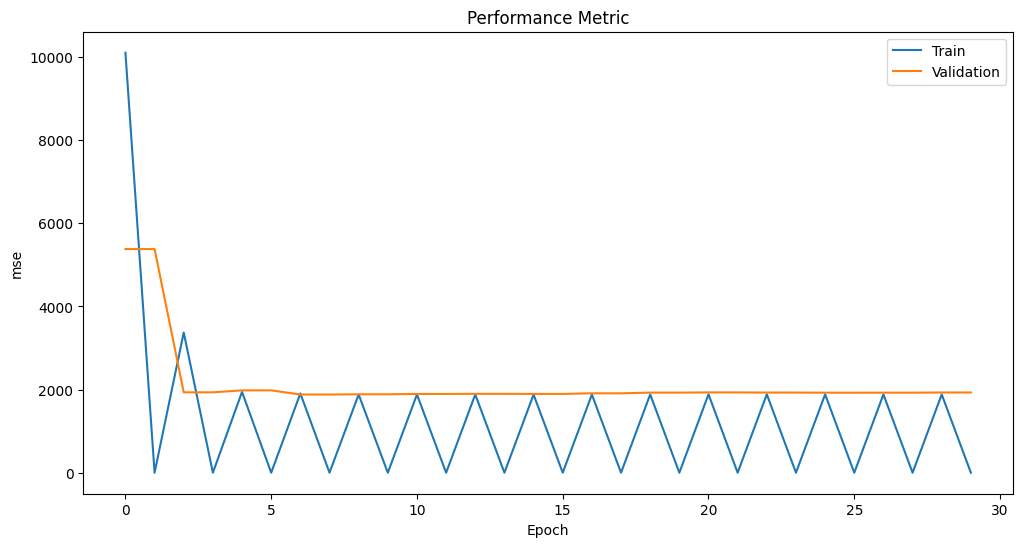

In [26]:
fl = ForecastLSTM()
fl.fit_lstm(
    df=df_train,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    **lstm_params,
)

In [27]:
df_fcst_val = fl.forecast_validation_dataset()
val_loss = calculate_metrics(df_fcst=df_fcst_val)[metrics[0]]
print(f"{metrics[0]} of validation dataset: {val_loss.round(3)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━